In [1]:
from bs4 import BeautifulSoup
import os
import pandas as pd
from unidecode import unidecode
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
list_review_text = {
    "contribution" : "Please describe the contribution of the paper",
    "strenghts" : "Please list the main strengths of the paper",
    "weakness" : "Please list the main weaknesses of the paper",
    "clarity" : "Please rate the clarity and organization of this paper",
    "repro" : "Please comment on the reproducibility of the paper",
    "detailed" : "Please provide detailed and constructive comments for the authors",
    "rate" : "Rate the paper on a scale of 1-8, 8 being the strongest",
    "justifictation" : "Please justify your recommendation.",
    "number of paper": "Number of papers in your stack",
    "ranking" : "What is the ranking of this paper in your review stack?",
    "confidence" : "Reviewer confidence",
    "rate rebuttal" : "[Post rebuttal] After reading the author’s rebuttal, state your overall opinion of the paper if it has been changed",
    "justification rebuttal" : "[Post rebuttal] Please justify your decision",
}

list_categories_str = [ "contribution", "strenghts", "weakness", "repro", "detailed", "justifictation" ] #"contribution", "strenghts", "weakness", "repro", "detailed", "justifictation"
list_categories_scores = ["clarity", "rate", "confidence", "rate rebuttal"]

columns_reviews = ["id", "category", "title" ,"review1" ,"review2" , "review3", ]
columns_statistics = ["id", "category", "title" , "words1", "words2", "words3"]

In [3]:
# Get the list of all the html files from the year chosen
def get_accepted_paper_list(year: str = "2023"):
    """
    Get the list of all html files
    """

    miccai_website_path = "https://conferences.miccai.org"
    path_online_list = miccai_website_path + f"/{year}/papers/"

    reponse = urllib.request.urlopen(path_online_list)
    contenu_web = reponse.read().decode('UTF-8')
    soup = BeautifulSoup(contenu_web, "html.parser")

    all = soup.find_all('a')
    paper_list = [(miccai_website_path + link.get('href')) for link in all if link.get('href').endswith('html')]

    return paper_list

In [4]:
year_ = "2022"
paper_list = get_accepted_paper_list(year=year_)
print(paper_list)

['https://conferences.miccai.org/2022/papers/001-Paper1347.html', 'https://conferences.miccai.org/2022/papers/002-Paper1233.html', 'https://conferences.miccai.org/2022/papers/003-Paper1512.html', 'https://conferences.miccai.org/2022/papers/004-Paper2655.html', 'https://conferences.miccai.org/2022/papers/005-Paper1525.html', 'https://conferences.miccai.org/2022/papers/006-Paper1155.html', 'https://conferences.miccai.org/2022/papers/007-Paper1247.html', 'https://conferences.miccai.org/2022/papers/008-Paper0063.html', 'https://conferences.miccai.org/2022/papers/009-Paper1374.html', 'https://conferences.miccai.org/2022/papers/010-Paper1785.html', 'https://conferences.miccai.org/2022/papers/011-Paper1016.html', 'https://conferences.miccai.org/2022/papers/012-Paper0202.html', 'https://conferences.miccai.org/2022/papers/013-Paper0975.html', 'https://conferences.miccai.org/2022/papers/014-Paper1405.html', 'https://conferences.miccai.org/2022/papers/015-Paper1881.html', 'https://conferences.mic

In [5]:
def extract_reviews(paper, df_reviews, df_stats, year="2023",  category= "repro"):
    
    # open html webpage and extract with BeautifulSoup
    reponse = urllib.request.urlopen(paper)
    contenu_web = reponse.read().decode('UTF-8')
    soup = BeautifulSoup(contenu_web, "html.parser")

    if year == "2023" :
        paper_title = soup.find("title").get_text().rstrip("MICCAI 2023 - Accepted Papers, Reviews, Author Feedback").rstrip(' |')
    elif year == "2022" :
        paper_title = soup.find("title").get_text().rstrip("MICCAI 2022 - Accepted Papers and Reviews").rstrip(' |')

    paper_id = Path(paper).name[:13]
    text = list_review_text[category]
    repro_reviews_paragraph = soup.find_all(lambda tag: tag.name == "li" and text in tag.text)
    repro_exact_text = soup.find(lambda tag: tag.name == "strong" and text in tag.text).get_text()

    i=0
    for review in repro_reviews_paragraph[:3]:
        i +=1
        tmp_review = unidecode(review.get_text().strip(repro_exact_text))
        tmp_review = tmp_review.strip("\n")
        tmp_review = tmp_review.replace("\n          \n"," ")
        tmp_review = tmp_review.replace("\t", " ")
        tmp_review = tmp_review.replace("\n\n\n\n"," ")
        tmp_review = tmp_review.replace("\n\n\n"," ")
        tmp_review = tmp_review.replace("\n\n"," ")
        tmp_review = tmp_review.replace("\n"," ")
        tmp_review = tmp_review.replace("\t", " ")

        df_reviews.loc[(paper_id, unidecode(paper_title)), (category, f"review {i}")]=tmp_review
        df_stats.loc[(paper_id, unidecode(paper_title)), (category, f"review {i}")]=len(str(tmp_review).split())



In [6]:

def extract_reproducibility_paragraph(paper_list, year= "2023"):
    # Extract the reproducibility paragraph from the reviews and export as csv file
    iterables = [list_categories_str, ["review 1", "review 2", "review 3"]]

    index_line = pd.MultiIndex.from_product(iterables, names=["category", "review"])
    index_column = pd.MultiIndex.from_product( [[], []], names=["id", "title"])

    df_reviews = pd.DataFrame(index = index_column, columns=index_line)
    df_stats = pd.DataFrame(index = index_column, columns=index_line)

    for paper in paper_list:
        for category in list_categories_str:
             
            extract_reviews(paper, df_reviews, df_stats, year, category)

    return df_reviews, df_stats

In [9]:
# create th output directory 
output_directory = Path("../miccai2022/")
if not output_directory.is_dir():
    os.mkdir(output_directory)
path_all_reviews = output_directory / 'all_reviews.csv'
path_all_stats = output_directory / 'all_stats.csv'

In [10]:
# extract 33 min  
if (not path_all_reviews.is_file()) or (not path_all_stats.is_file()):

    print(f"Extract reviews and count word for year {year_}")
    df_all_reviews, df_all_stats = extract_reproducibility_paragraph(paper_list, year_)

    df_all_reviews.to_csv(path_all_reviews, index = True, sep="\t", encoding='utf-8')
    df_all_stats.to_csv(path_all_stats, index = True, sep="\t", encoding='utf-8')

else:
    import pandas as pd
    print(f"Import tsv from {output_directory}")

    df_all_reviews = pd.read_csv(path_all_reviews, sep= "\t",  header=[0, 1], index_col=[0,1], skip_blank_lines=True)
    df_all_stats = pd.read_csv(path_all_stats, sep= "\t",  header=[0, 1], index_col=[0,1], skip_blank_lines=True)


Import tsv from ../miccai2022


In [11]:
def count_total_words(df_all_stats, output_directory= "../results"):

    for id, id_df in df_all_stats.groupby(level=0):
        for _, title in id_df.index.values:
            for i in range (1,4):
                df_all_stats.loc[(id,title), ("total", f"review {i}")] = 0
                for category in list_categories_str :
                    df_all_stats.loc[(id,title), (category, "all reviews")] = 0
                    
            for category in list_categories_str :
                for i in range (1,4):
                    df_all_stats.loc[(id,title), ("total", f"review {i}")] += df_all_stats.loc[(id,title), (category, f"review {i}")]

                    df_all_stats.loc[(id,title), (category, "all reviews")] += df_all_stats.loc[(id,title), (category, f"review {i}")] 
                            
    df_all_stats.sort_index(axis = 1, ascending=True, inplace=True)
    df_all_stats.to_csv(os.path.join(output_directory ,f'all_stats.csv'), index = True, sep="\t", encoding='utf-8')
    
    return df_all_stats

In [12]:
# Count total nomber of words for each reviews and in total
df_all_stats = count_total_words(df_all_stats=df_all_stats, output_directory=output_directory)

In [13]:
def save_hist(df_all_stats, output_directory= "../results"):

    histo_path = Path(output_directory) / "histo"
    if not histo_path.is_dir():
        os.mkdir(histo_path)

    for category in list_categories_str + ["total"] :

        list = df_all_stats.loc[:,(category, "review 1")].values.tolist() + df_all_stats.loc[:,(category, "review 2")].values.tolist() + df_all_stats.loc[:,(category, "review 3")].values.tolist()

        plt.figure(figsize=(8, 6))
        plt.hist(list, bins=100, alpha=0.5, edgecolor='k', label=f"Word count per review for {category}")

        plt.title('Distribution of Word Counts')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(histo_path, f"{category}_hist_count_words"))

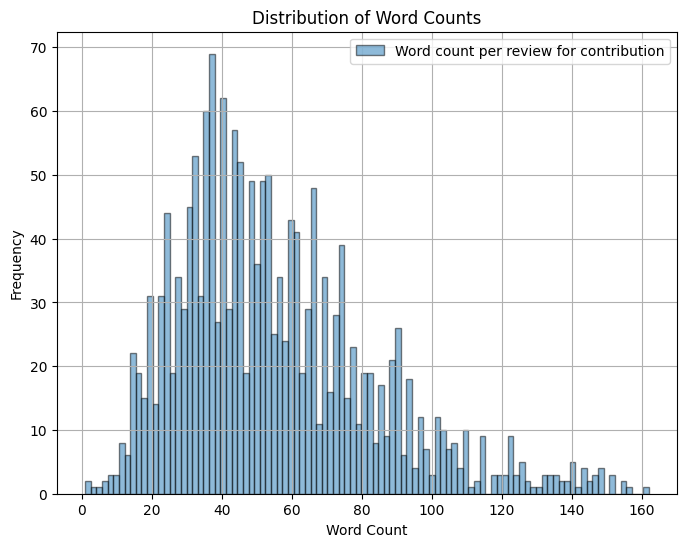

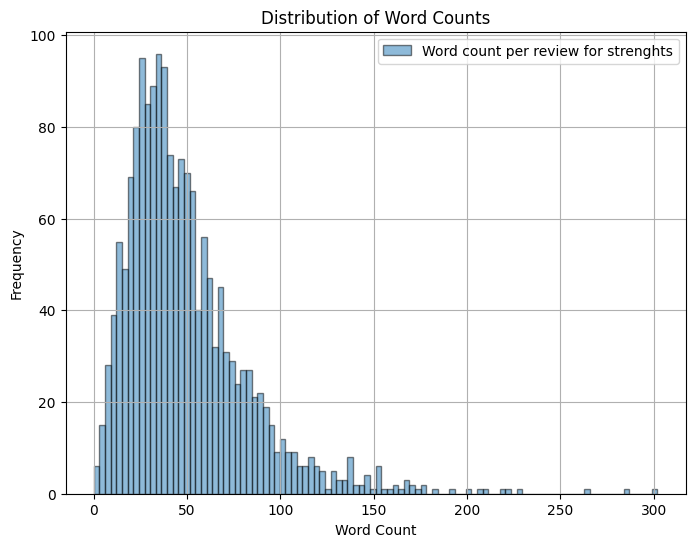

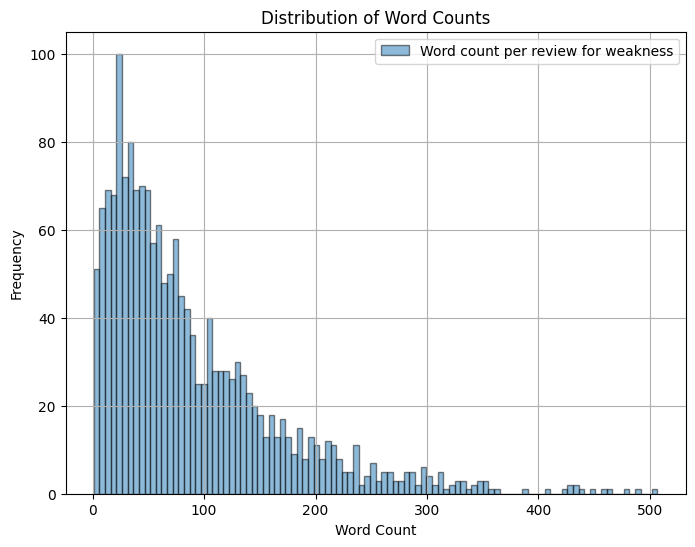

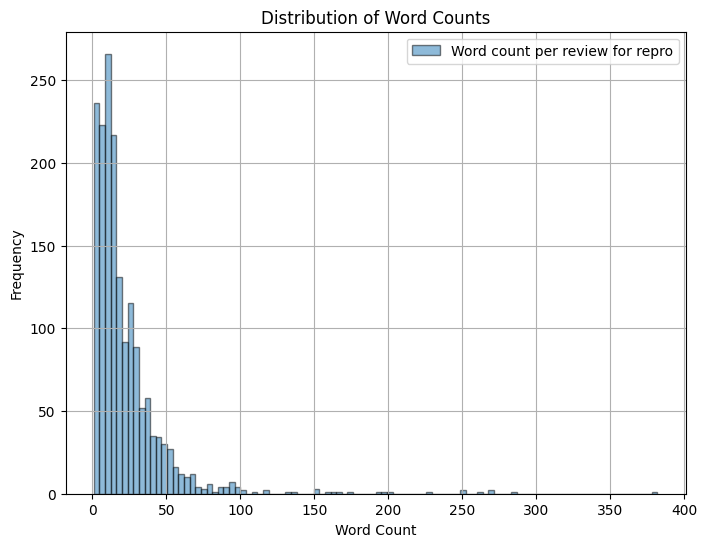

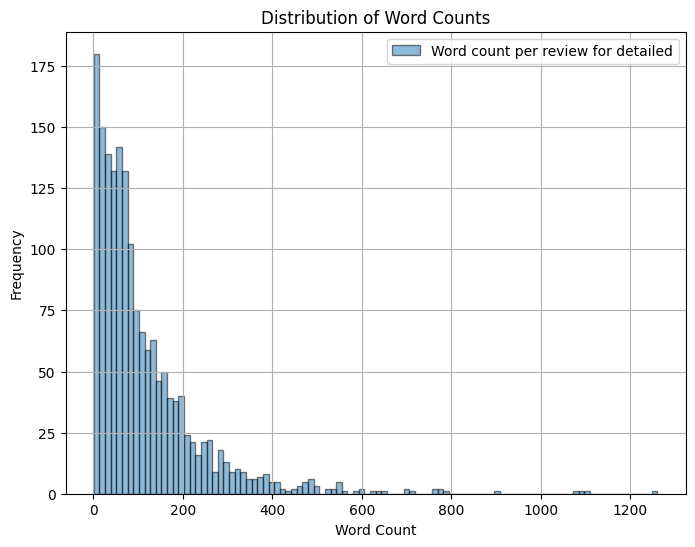

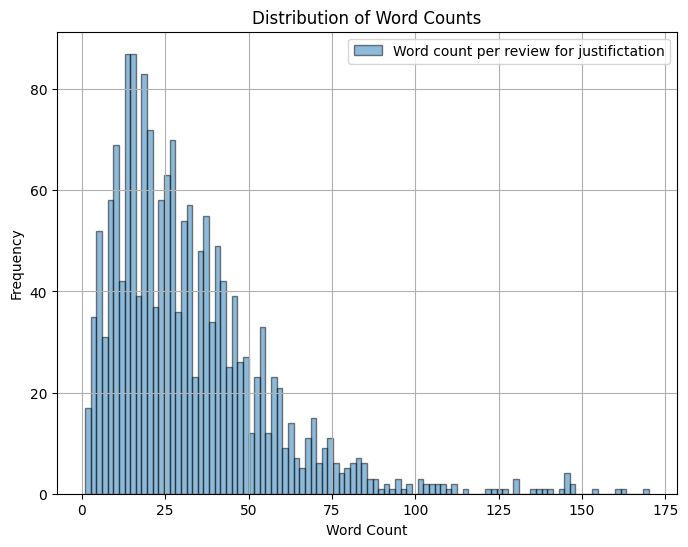

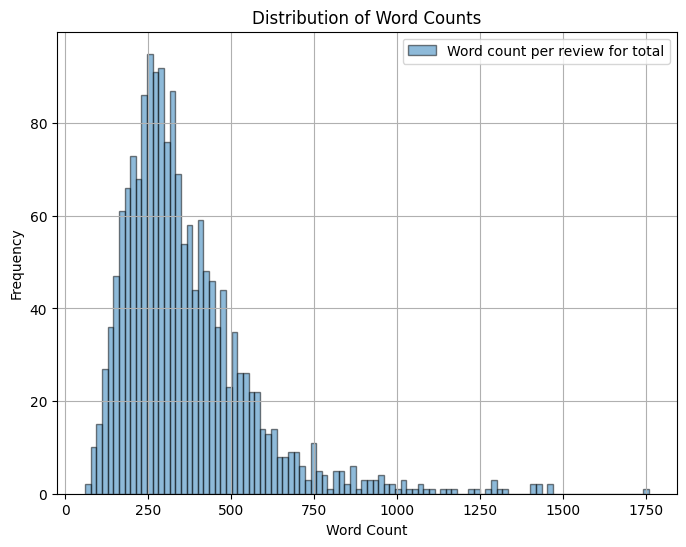

In [23]:
# Create histogramme for each category and save it 
save_hist(df_all_stats, output_directory)

In [14]:
def get_repro_copy_paste(df_all_reviews, output_directory= "../results", threshold:int  = 10 ):

    from copy import copy
    df_all_reviews_wo_copy_paste = copy(df_all_reviews)
    df_bad_reviews = pd.DataFrame(columns=columns_reviews)
    df_bad_reviews.set_index(["id", "category"], inplace= True)
    
    for id, id_df in df_all_reviews.groupby(level=0):
        print(id_df)
        for _, title in id_df.index.values:
            for category in list_categories_str:
                if category != "repro" :
                    for i in range(1,3):
                        repro = id_df.loc[(id,title), ("repro", f"review {i}")]
                        cate = id_df.loc[(id, title), (category, f"review {i}")]
                        if len(str(repro)) > threshold : 
                            if str(repro) in str(cate):
                                df_bad_reviews.loc[(id, title), (category, f"review {i}")] = id_df.loc[(id, title), (category, f"review {i}")]
                                df_all_reviews_wo_copy_paste.drop((id, title), inplace=True)
        
    df_all_reviews_wo_copy_paste.to_csv(os.path.join(output_directory ,f'all_reviews_wo_copy_paste.csv'), index = True, sep="\t", encoding='utf-8')
    df_bad_reviews.to_csv(os.path.join(output_directory ,f'copy_paste_reviews_{threshold}.csv'), index = True, sep="\t", encoding='utf-8')


In [15]:
# Get the list of review where the reviewer had copy/paste the review repro from another review
get_repro_copy_paste(df_all_reviews=df_all_reviews, output_directory=output_directory)
# not working ???? 

category                                                                                               contribution  \
review                                                                                                     review 1   
id            title                                                                                                   
001-Paper1347 3D CVT-GAN: A 3D Convolutional Vision Transform...  This paper aims to reconstruct standard-dose P...   

category                                                                                                             \
review                                                                                                     review 2   
id            title                                                                                                   
001-Paper1347 3D CVT-GAN: A 3D Convolutional Vision Transform...  The paper proposed a 3D convolutional vision t...   

category                                      

/var/folders/03/3_l2qbvj5sjf070rq3vks9rc001396/T/ipykernel_5661/2954815753.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1: The main ideas of the paper are known or incremental advances over past work.  Besides, the incorporation of the K-spcace has also been employed in some medical image processing works. 2: The number of images are too small to obtain meaningful training results. There are only 75 samples of BRATS2018 dataset and 25 samples of IXI dataset for training. 3: The experimental setup details are incomplete. For example, the value of  and  in Equation(3) is unclear. The authors should provide the value of the hyper-parameters for the reproduction. 4: The code and the data are not available to aid reproducibility.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_bad_reviews.loc[(id, title), (category, f"review {i}")] = id_df.loc[(id, title), (category

category                                                                                               contribution  \
review                                                                                                     review 1   
id            title                                                                                                   
139-Paper0232 Deep treatment response assessment and predicti...  The paper proposes a longitudinal approach to ...   

category                                                                                                             \
review                                                                                                     review 2   
id            title                                                                                                   
139-Paper0232 Deep treatment response assessment and predicti...  Authors have proposed a method to predict and ...   

category                                      

KeyError: ('419-Paper1023', 'RemixFormer: A Transformer Model for Precision Skin Tumor Differential Diagnosis via Multi-modal Imaging and Non-imaging Data')

In [16]:
def resume(df_all_stats, output_directory= "../results"):
    import statistics
    df_resume = pd.DataFrame(columns=["category","mean","max", "min", "mediane", "variance"], )
    df_resume.set_index(["category"], inplace= True)
    
    for category in list_categories_str + ["total"]:
        list_words = df_all_stats.loc[:,(category, "review 1")].values.tolist() + df_all_stats.loc[:,(category, "review 2")].values.tolist() + df_all_stats.loc[:,(category, "review 3")].values.tolist()
        df_resume.loc[(category), "mean"]  = statistics.mean(list_words)
        df_resume.loc[(category), "mediane"]  = statistics.median(list_words)
        df_resume.loc[(category), "max"]  = max(list_words)
        df_resume.loc[(category), "variance"]  = statistics.variance(list_words)
        df_resume.loc[(category), "min"]  = min(list_words)

    df_resume.to_csv(os.path.join(output_directory ,f'stats_resume.csv'), index = True, sep="\t", encoding='utf-8')

In [17]:
# Create a tsv file file with some basic stats about the number of words
resume(df_all_stats, output_directory=output_directory)


ValueError: cannot convert NaN to integer ratio

In [18]:
def count_checklist(df_all_reviews, output_directory= "../results", category = "repro"):

    df_checklist  = pd.DataFrame(index=df_all_reviews.index)
    for id, id_df in df_all_reviews.groupby(level=0):
        for _, title in id_df.index.values:
            for i in range(1,4):
                review = str(df_all_reviews.loc[(id, title), (category, f"review {i}")])

                if ("check-list" in review) or ("checklist" in review) or ("check list" in review):
                    df_checklist.loc[(id, title), (category, f"review {i}")] = df_all_reviews.loc[(id, title), (category, f"review {i}")]

    df_checklist.to_csv(os.path.join(output_directory ,f'nb_checklist_{category}.csv'), index = True, sep="\t", encoding='utf-8')


In [19]:
# Count the number of occurrences of the word checklist in the repro reviews
count_checklist(df_all_reviews=df_all_reviews, output_directory=output_directory, category="repro")

/var/folders/03/3_l2qbvj5sjf070rq3vks9rc001396/T/ipykernel_5661/2201838915.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'based on the checklist, yes.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_checklist.loc[(id, title), (category, f"review {i}")] = df_all_reviews.loc[(id, title), (category, f"review {i}")]
/var/folders/03/3_l2qbvj5sjf070rq3vks9rc001396/T/ipykernel_5661/2201838915.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'The code and data can be released according to the reproducibility checklist.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_checklist.loc[(id, title), (category, f"review {i}")] = df_all_reviews.loc[(id, title), (category, f"review {i}")]
/var/folders/03/3_l2qbvj5sjf070rq3vks9rc001396/T/ipykernel_5661/220183891

In [20]:
def create_rating_excel(df_all_reviews, output_directory="../results"):
    df_repro_excel = df_all_reviews.loc[:, ("repro")]
    df_repro_excel.to_excel(os.path.join('../rating' ,'output.xlsx'))
    


In [21]:
# Save the excel file with the repro reviews to create the rating file
create_rating_excel(df_all_reviews= df_all_reviews, output_directory= output_directory)

In [ ]:
# TODO 

# spliter les fonctions 
# print plus de trucs pour que ca soit plus beau et lisible 


# correler la longueur de la review repro a la longueur totale
# Donner des examples au hasard
#   - entre 40 et 60 centiles
#   - entre 0 et 30 centiles
# extraire les scores !!!
